In [1]:
# Import libraries
import sys 
sys.path.append('../')
import numpy as np 
import pandas as pd 
import os
import warnings
import torch
from torchvision import datasets, transforms, models
from torchvision.models import vgg19
from torch.autograd import Variable
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from sklearn.exceptions import ConvergenceWarning
import sklearn.linear_model as slm
import sklearn.feature_selection as skf
import sklearn.preprocessing as skp
import util
import cv2
import pickle

In [2]:
# Augment with CHH data
X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
# with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
#     Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]

lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
X_all_c = X_all_c.reshape(X_all_c.shape[0],-1)
X_all_c = np.append(X_all_c,pre_imp.reshape(-1,1),axis=1)
subsc = subject_id_corr

Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

In [3]:
pt_model = vgg19(weights='DEFAULT')
pt_model
for param in pt_model.parameters():
    param.required_grad = False

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Maximum volume found at slice 33 for case 1
Maximum volume found at slice 35 for case 2
Maximum volume found at slice 33 for case 3
Maximum volume found at slice 34 for case 4
Maximum volume found at slice 34 for case 5
Maximum volume found at slice 33 for case 6
Maximum volume found at slice 35 for case 7
Maximum volume found at slice 33 for case 8
Maximum volume found at slice 34 for case 9
Maximum volume found at slice 33 for case 10
Maximum volume found at slice 34 for case 11
Maximum volume found at slice 34 for case 13
Maximum volume found at slice 33 for case 14
Maximum volume found at slice 35 for case 16
Maximum volume found at slice 34 for case 18
Maximum volume found at slice 35 for case 19
Maximum volume found at slice 34 for case 20
Maximum volume found at slice 33 for case 21
Maximum volume found at slice 33 for case 22
Maximum volume found at slice 35 for case 23
Maximum volume found at slice 34 for case 24
Maximum volume found at slice 34 for case 25
Maximum volume foun

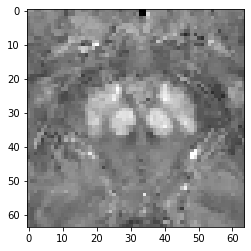

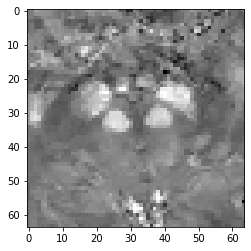

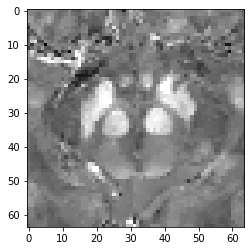

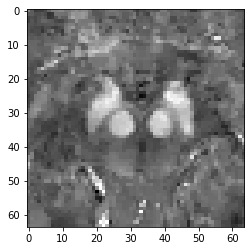

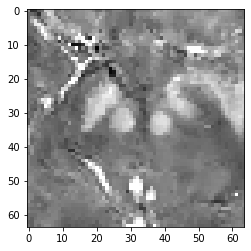

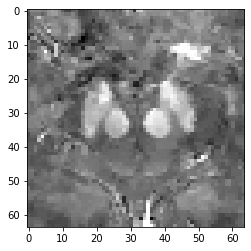

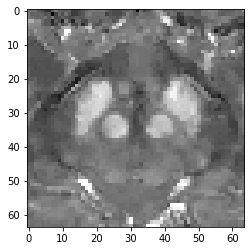

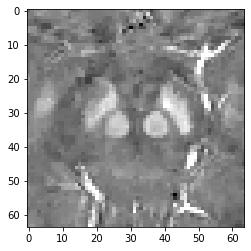

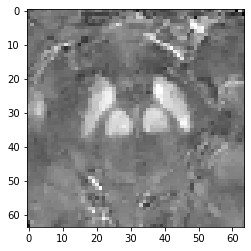

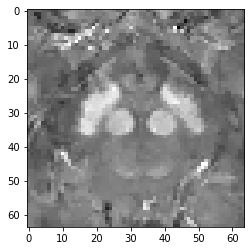

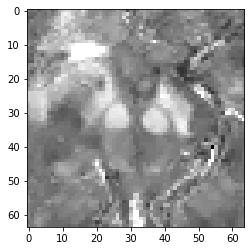

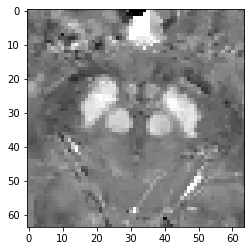

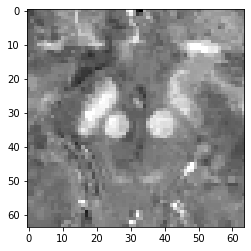

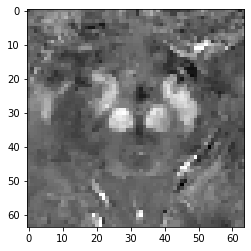

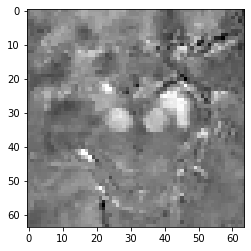

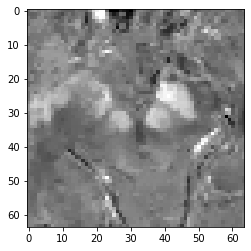

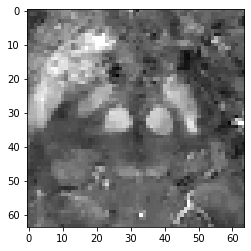

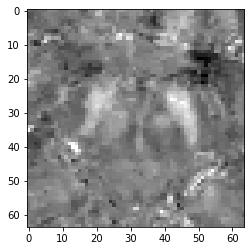

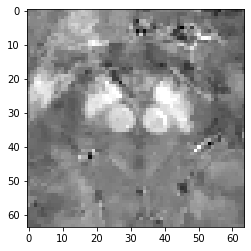

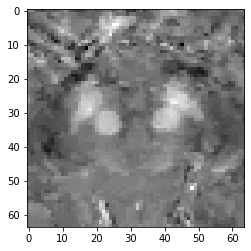

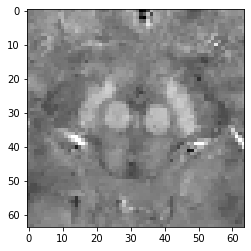

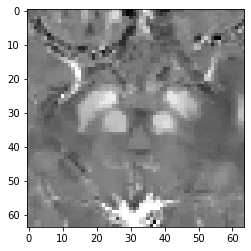

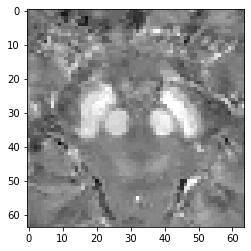

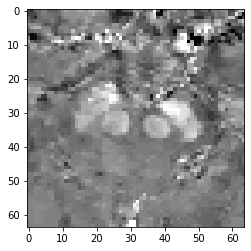

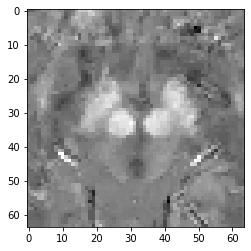

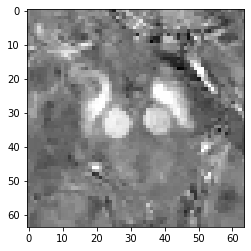

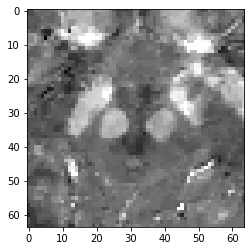

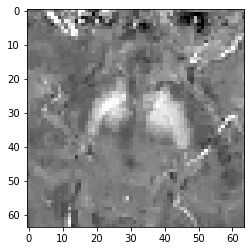

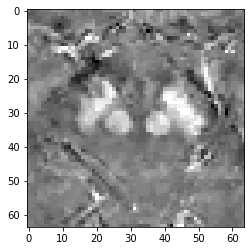

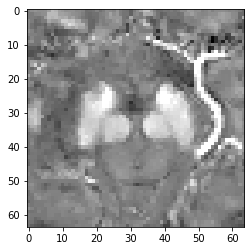

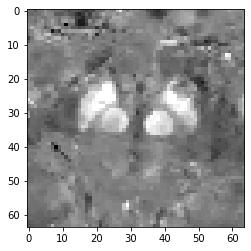

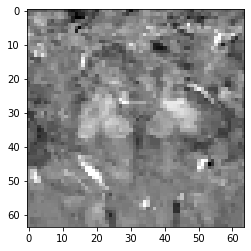

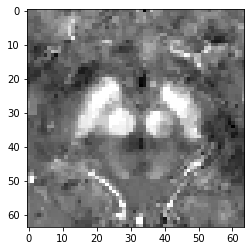

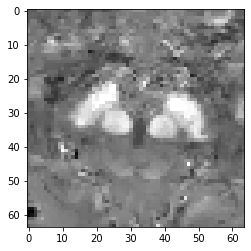

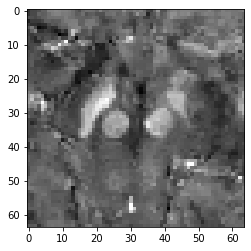

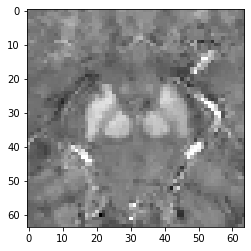

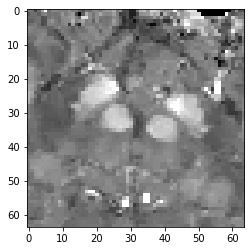

In [4]:
subs_init = subsc
X_img, subsc0, per_change0, pre_metric0, pre_imp0 = util.slice_pick(subsc=subs_init,
                        per_change=per_change,
                        pre_metric=pre_updrs_off,
                        pre_comp=pre_imp,
                        pshape=(64,64,64),
                        roi_l=0,roi_u=4,
                        mask_crop_output=False,mask_output=False,o_index=False,
                        file_path='/home/ali/RadDBS-QSM/src/jupyter/mlp/torch/X_chh.pt',
                        qsm_path='/home/ali/RadDBS-QSM/data/nii/chh/qsm/',
                        seg_prefix='/home/ali/RadDBS-QSM/data/nii/chh/seg/',
                        save_image=False,
                        L=10,
                        new_prefix=False,
                        img_directory='/home/ali/RadDBS-QSM/src/jupyter/mlp/chh_tensor_slices_0/',
                        visualize=False,
                        reload=True)
Xr = torch.zeros((len(X_img),X_img[0].shape[0],X_img[0].shape[1]))
for j in np.arange(len(X_img)):
    img = X_img[j]
    img[img>250] = 250
    img[img<-250] = -250
    Xr[j,:,:] = img
    plt.imshow(np.rot90(img.cpu()),cmap="gray")
    plt.show()
    np.save('./chh_tensor_slices_0/case_'+str(subsc[j])+'_0.npy',img.cpu())

In [5]:
pt_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
util.get_layer_output(X_img[j],pt_model,{"features": "layer36"})['layer36'].detach().numpy().shape

(1, 512, 2, 2)

In [11]:
# Get the last max pooling layer
pt_model.__getattr__('features')[36].register_forward_hook('features')
#fc3.register_forward_hook(get_activation('fc3'))

: 

In [ ]:
Z = []
zc1 = []
x = []
for j in np.arange(len(X_img)):
    x_img = X_img[j]
    x_img[x_img>250] = 250
    x_img[x_img<-250] = -250
    x.append(x_img.cpu().numpy())
    Z.append(util.get_latent_rep(X_img[j],pt_model).detach().numpy())
    zc1.append(util.get_layer_output(X_img[j],pt_model,{"layer4.2.conv3": "layer4"})['layer4'].detach().numpy())
    plt.imshow(Z[j].reshape((10,100)))

In [ ]:
X = np.asarray(x)
Zc1 = np.asarray(zc1)

In [ ]:
# plt.figure(figsize=(9, 5), dpi=100)

# plt.imshow(np.rot90(np.hstack((X[0:9,:].reshape((-1,64)),X[9:18,:].reshape((-1,64)),
#                       X[18:27,:].reshape((-1,64)),X[27:36,:].reshape((-1,64)),
#                      X[36:45,:].reshape((-1,64))))),cmap='gray')
                     
# plt.style.use('dark_background')
# plt.axis('off')


In [ ]:
Z = np.asarray(Z)

In [ ]:
plt.figure(figsize=(10, 10), dpi=100)

plt.imshow(np.squeeze(Z))
                     
plt.style.use('dark_background')
plt.axis('off')


In [ ]:
plt.imshow(np.squeeze(Zc1[0])[0,:,:])

In [ ]:
# for j in np.arange(Zc1.shape[2]):
#     plt.figure(figsize=(9, 5), dpi=100)
#     c = j
#     plt.imshow(np.rot90(np.hstack((Zc1[0:9,0,c,:,:].reshape(-1,6),Zc1[9:18,0,c,:,:].reshape(-1,6),
#                         Zc1[18:27,0,c,:,:].reshape(-1,6),Zc1[27:36,0,c,:,:].reshape(-1,6),
#                         Zc1[36:45,0,c,:,:].reshape(-1,6)))),cmap='gray')
#     plt.imsave("./channels/fig"+str(j)+".jpeg",(np.rot90(np.hstack((Zc1[0:9,0,c,:,:].reshape(-1,6),Zc1[9:18,0,c,:,:].reshape(-1,6),
#                         Zc1[18:27,0,c,:,:].reshape(-1,6),Zc1[27:36,0,c,:,:].reshape(-1,6),
#                         Zc1[36:45,0,c,:,:].reshape(-1,6))))),cmap='gray')
                        
#     plt.style.use('dark_background')
#     plt.axis('off')



In [ ]:
rerecord = 0
if rerecord == 1:
    image_folder = 'channels'
    video_name = 'channels.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".jpeg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [ ]:
r = np.zeros(len(per_change))
err_var = np.zeros(len(per_change))
rerror = np.zeros(len(per_change))
kappa = []
results_ls = np.zeros(len(per_change))
scaler = skp.StandardScaler()
Z = np.asarray(Zc1.reshape(Zc1.shape[0],-1))
Z = scaler.fit_transform(np.squeeze(Z))
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = Z[train_index]
    X_test = Z[test_index]
    y_train = per_change[train_index].ravel()
    y_test = per_change[test_index]

    X0_ss0 = X_train.reshape(X_train.shape[0],-1)
    X_test_ss0 = X_test.reshape(X_test.shape[0],-1)
    # Cross validation
    cvn = 5
    # X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
    #                                             X_train,train_index,X_test,test_index,pre_metric,ledd,False,False,False)
    lasso = slm.LassoCV(max_iter=1000,cv=cvn,n_jobs=-1,verbose=1)

    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.SelectKBest(skf.r_regression,k=10)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss)
      
    print('Lasso predicts',str(np.round(results_ls[j],2)),
              'for case with',str(np.round(per_change[j],2)))
              #'with regularization',str(est_ls.alpha_))

In [ ]:
util.eval_prediction(np.vstack((np.squeeze(pre_imp),
                               results_ls.T,
                               )),
                               np.squeeze(per_change),
                               ['LCT',
                                'Lasso',
                                ],(20,10))
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')